# Assignment objective

We have data from Raleigh, NC, where we recently deployed a flyer program in order to increase public awareness of the possibility of taking a Pagaya loan. You objective is to assess the potency of the flyer program in terms of activation by analyzing production and TU data obtained from the town.


# Basic imports 

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

# Data preparation

## Data from TU 

To begin with, upload TUs credit information from the relevant quarter (which is 2018Q3). This data is available in our `s3` path under the name `tu_gen_data2018Q3.parquet`. To get to our `s3` path import `DATA_FILES_PATH` from `pagayapro.paths.data_paths`

In [126]:
from pagayapro.paths.data_paths import DATA_FILES_PATH

read the parquet file from `s3`. Only read the columns ["sequence_num", "credit_score", "listing_term", "int_rate", "loan_amnt", "monthly_pmt", "original_state"]

In [127]:
tu_data= pd.read_parquet(
    os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"),
                columns = ["sequence_num", "credit_score", 
                           "listing_term", "int_rate" ,
                           "loan_amnt", "monthly_pmt", 
                           "original_state"])

Output the first 5 rows of tu_data

In [128]:
tu_data.head()

,sequence_num,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,814,36.0,7.86,5500.0,172.0,MI
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,800,36.0,7.91,20000.0,626.0,NM
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,653,36.0,30.51,3674.0,157.0,SD
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,623,60.0,23.46,14056.0,400.0,NC
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,627,60.0,25.55,8659.0,257.0,TN


## Activation data 

Your data regarding activation arrives as forms, detailing the loan amount, interest rate offered to the client and whether he or she accepted the offer. These are available on the assignment's `s3` path, which you can import from `pagayapro.path.data_paths` under the name `ASSIGNMENT1_DATA`, in the subdirectory `offers`. 

In [129]:
from pagayapro.paths.data_paths import ASSIGNMENT1_DATA
import glob

Read all files in the subdirectory `offers` of `ASSIGNMENT1_DATA` whose name contains the substring `raleigh`.

In [130]:
raleigh_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*raleigh*")
    )
)

how many forms are there?


In [131]:
len(raleigh_forms)

769

Read all the form files and create a table which contains only the last offer given to each borrower. Call this dataframe `raleigh_df`.

In [132]:
raleigh_df = pd.concat(map(pd.read_csv, raleigh_forms))

How many rows are there in your table? How many distict ids?

In [133]:
len(raleigh_df["id"].unique())

8792

In [134]:
raleigh_df.shape[0]

13362

How can you explain the duplicate ids? Sample 5 ids with multiple lines and display them.

The reason is that we can see for each person few offers.

In [135]:
indexes = raleigh_df["id"].value_counts()[0:5].index
indexes = indexes.to_numpy()
print(indexes)

['00205f2f999895bde728aebcd83707fa204ec44e203b97bbd7dd3c902c3d2245'
 '29e6cc12ee6a24d30944fbb2d6118c0d5cd3b0f6ab37e5d6f0edcce50e2975c7'
 'a3b905d85e76f7db918e1427ac20013cf54a7f974a4ef90c10e17866e542ce09'
 '578489ad64099a387298d9a114d545cf9e5fe728493370a8da01ca40768b113c'
 '49dc4fab8a8438e2ebe01a909d14b7b3b16e984f1de68e7efcf8b0ec0a4e9504']


In [136]:
raleigh_df.query('id in @indexes')

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
25,578489ad64099a387298d9a114d545cf9e5fe728493370...,c9880b37d328502821437dfcaa279974e3c6b60b407f8f...,18870.0,10.731947,False,2018-02-19
14,a3b905d85e76f7db918e1427ac20013cf54a7f974a4ef9...,daf0ecb3b0d3359758228d3998fa331b561dcfd0964684...,5000.0,27.994706,False,2018-05-17
20,49dc4fab8a8438e2ebe01a909d14b7b3b16e984f1de68e...,496f2099f16c5d70d76e41aa5c39b6d9ae9d60ce80788b...,4325.0,14.911652,False,2018-06-12
18,578489ad64099a387298d9a114d545cf9e5fe728493370...,c9880b37d328502821437dfcaa279974e3c6b60b407f8f...,18870.0,10.273592,False,2018-06-29
29,29e6cc12ee6a24d30944fbb2d6118c0d5cd3b0f6ab37e5...,643affdd1f463d37c0a3101fea55d11a012063ae7456f9...,7900.0,14.733852,False,2018-07-17
8,578489ad64099a387298d9a114d545cf9e5fe728493370...,c9880b37d328502821437dfcaa279974e3c6b60b407f8f...,18870.0,7.040000,False,2018-11-14
17,00205f2f999895bde728aebcd83707fa204ec44e203b97...,6061825c161146555925ce39fb27c935fb5899f39ce94b...,25000.0,14.026984,False,2018-12-28
11,00205f2f999895bde728aebcd83707fa204ec44e203b97...,6061825c161146555925ce39fb27c935fb5899f39ce94b...,25000.0,13.466467,False,2019-03-04
10,49dc4fab8a8438e2ebe01a909d14b7b3b16e984f1de68e...,496f2099f16c5d70d76e41aa5c39b6d9ae9d60ce80788b...,4325.0,14.504225,False,2019-06-26
10,a3b905d85e76f7db918e1427ac20013cf54a7f974a4ef9...,daf0ecb3b0d3359758228d3998fa331b561dcfd0964684...,5000.0,26.605121,False,2019-07-15


Drop all lines in the dataframe which contain irrelevant information.

In [137]:
raleigh_df_without_duplicates = raleigh_df.sort_values(by=['offer_date']).drop_duplicates(subset='id', keep='last')

In [138]:
raleigh_df = raleigh_df_without_duplicates.set_index("id")

In [139]:
raleigh_df

,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
id,,,,,
743200d3e4cc1f6f860e121294248d611350f257a7bc83df1c5b33df7bc86f94,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01
9b785f1c83a022947857aa109de2aeb3c2c54231b910ed0d6b63f0b6781cafa8,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,7000.0,17.98,False,2018-01-01
0f0b253809bb99eb4cd76ba8089f5746f2345ae3c595358c3f6fbbc52cb19c63,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,3505.0,29.58,True,2018-01-01
e3e32f85cd78bb5002ccdc037c1818029f716e7a47911ed3b822de61c435e2c8,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01
3a72ae7a82244f811b37c48f57469b708207004f0111633d1b222fb75a12d867,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01
...,...,...,...,...,...
a2b763a8d324fd4bdd37ac7ad5bee9d62f936c52dd3c951b7769514c05659642,77b3642dd8bc768d19a6b80466e5f7113e7372e1b1aa03...,17725.0,16.10,False,2020-12-10
69b282258fdc0b55336a5c88e94dd0c0a4fdac7a6a448bc3fd0d4329b6f67ad5,8b1ed3ba66907feb4c208578846eddf03fc09c8a605048...,15000.0,15.27,False,2020-12-10
46835ae976bb2c0790a1c283a74465be1b5a7cbd184198a5841419b809db983e,96be5e312cac0e00f7a0dc65d066f5da1de236336bd7c8...,10000.0,15.27,False,2020-12-10


What is the average interest rate offered to clients? What is the average among clients who accepted the offer?

In [140]:
raleigh_df["offered_interest_rate"].mean()

15.524284576888082

What is the percentage of activation in this dataframe?

In [141]:
raleigh_df["offer_accepted"].mean()*100

8.666969972702457

Enrich your dataframe with additioanl TU features by merging it with the `tu_data` df. Note that the two dataframe share the `id` and `sequence_num` features.

In [142]:
#raleigh_df_and_tu_data = pd.concat([raleigh_df, tu_data], axis=1)
raleigh_df_and_tu_data = raleigh_df.join(tu_data, how='left',lsuffix='_left', rsuffix='_right')
raleigh_df_and_tu_data

,sequence_num_left,requested_amount,offered_interest_rate,offer_accepted,offer_date,sequence_num_right,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state
id,,,,,,,,,,,,
743200d3e4cc1f6f860e121294248d611350f257a7bc83df1c5b33df7bc86f94,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,652,36.0,17.69,3000.0,108.0,NC
9b785f1c83a022947857aa109de2aeb3c2c54231b910ed0d6b63f0b6781cafa8,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,7000.0,17.98,False,2018-01-01,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,662,36.0,17.98,7000.0,253.0,NC
0f0b253809bb99eb4cd76ba8089f5746f2345ae3c595358c3f6fbbc52cb19c63,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,3505.0,29.58,True,2018-01-01,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,623,36.0,29.58,3505.0,148.0,NC
e3e32f85cd78bb5002ccdc037c1818029f716e7a47911ed3b822de61c435e2c8,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,735,36.0,12.56,6899.0,231.0,NC
3a72ae7a82244f811b37c48f57469b708207004f0111633d1b222fb75a12d867,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,661,36.0,12.97,3800.0,128.0,NC
...,...,...,...,...,...,...,...,...,...,...,...,...
a2b763a8d324fd4bdd37ac7ad5bee9d62f936c52dd3c951b7769514c05659642,77b3642dd8bc768d19a6b80466e5f7113e7372e1b1aa03...,17725.0,16.10,False,2020-12-10,77b3642dd8bc768d19a6b80466e5f7113e7372e1b1aa03...,618,60.0,16.10,17725.0,432.0,NC
69b282258fdc0b55336a5c88e94dd0c0a4fdac7a6a448bc3fd0d4329b6f67ad5,8b1ed3ba66907feb4c208578846eddf03fc09c8a605048...,15000.0,15.27,False,2020-12-10,8b1ed3ba66907feb4c208578846eddf03fc09c8a605048...,638,60.0,15.27,15000.0,359.0,NC
46835ae976bb2c0790a1c283a74465be1b5a7cbd184198a5841419b809db983e,96be5e312cac0e00f7a0dc65d066f5da1de236336bd7c8...,10000.0,15.27,False,2020-12-10,96be5e312cac0e00f7a0dc65d066f5da1de236336bd7c8...,694,36.0,15.27,10000.0,348.0,NC


What is the average credit score of the clients? What is the average among clients who accepted the offer?

In [143]:
raleigh_df_and_tu_data["credit_score"].mean()

689.821542311192

In [144]:
raleigh_df_and_tu_data[raleigh_df_and_tu_data["offer_accepted"] == True]["credit_score"].mean()

702.5446194225722

# Validations

Before we embark on a statistical test, let's do some validations to make sure that the Raleig sample is not somehow distinct from the general population. Our random sample from the general population is the TU data.

Create a histogram to describe the distribution of requested loan amounts in Raleigh and in the general population. Do the distributions look similar? (A good rule-of-thumb for the number of bins to use is the square-root of the number of unique value.)

In [145]:
df_list = [tu_data,raleigh_df_and_tu_data]
df_title_list = ['TU','raleigh']

In [146]:
def remove_out_liars(series):
    q_25 =  series.quantile(q=0.25, interpolation='linear')
    q_75 =  series.quantile(q=0.75, interpolation='linear')
    diff = q_75 - q_25
    upper_lim = q_75 + (3 *diff)
    lower_lim = q_25 - (3 *diff)
    precentage_of_out_liars = ((series.values > upper_lim) | (series.values < lower_lim)).sum() / series.size
    return lower_lim,upper_lim, precentage_of_out_liars

In [147]:
def plot_density_histogram(data_list,x_lable='x',y_lable='y',titles=[],func_flag='hist'):
    plt.figure(figsize=(12,12))
    for i, data in enumerate(data_list):
        plt.subplot(2, 2, i+1)
        bins = int(np.sqrt(len(data.unique())))
        if func_flag == 'hist':
            plt.hist(data, bins=bins,
                     density=True,
                     alpha=0.7, edgecolor='k', label='noisy')
        else:
            sns.distplot(data,bins=bins)
        plt.xlabel(x_lable)
        plt.ylabel(y_lable)
        lower_lim,upper_lim, precentage_of_out_liars = remove_out_liars(data)
        plt.xlim(lower_lim,upper_lim)
        plt.grid(True)
        # We also switch from counts to density histogram (pdf)
        if(len(titles) > i):
            plt.title(titles[i] + "  (Precent of outliars removed is: {}%".format(str(np.round(100*precentage_of_out_liars,2))))
        plt.tight_layout();

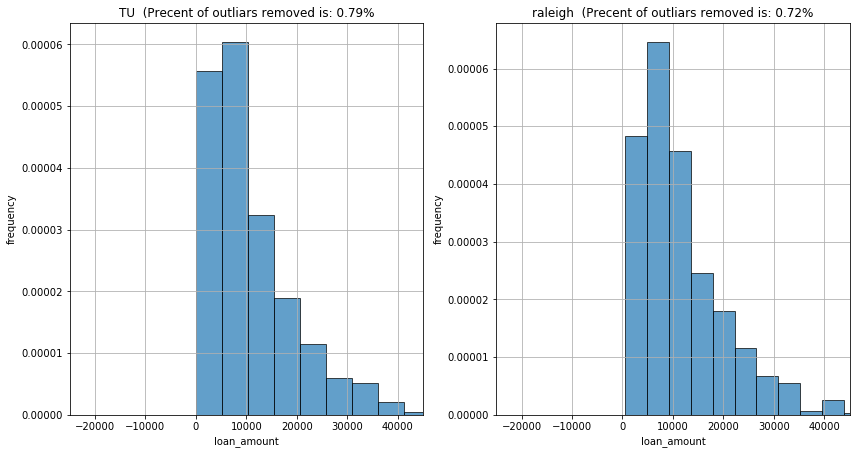

In [148]:
plot_density_histogram([df.loan_amnt for df in  df_list],'loan_amount','frequency',df_title_list)

Describe the loan amount distribution using `sns.distplot` in the Raleigh dataframe and in TU.

We also want to verify that the offered interest rate in Raleigh seem similar to those in the general population. 
Create a histogram to describe the distribution of offered interest rates in Raleigh and interest rates in the general population. Do the distributions look similar?

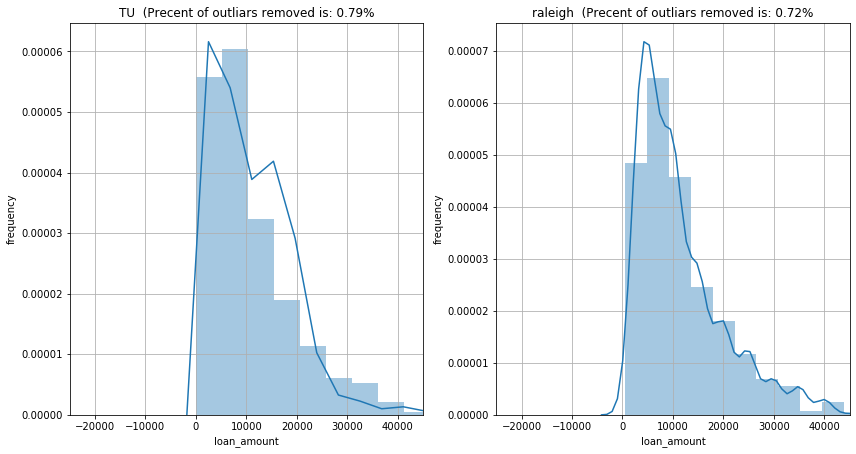

In [149]:
plot_density_histogram([df.loan_amnt for df in  df_list],'loan_amount','frequency',df_title_list,func_flag='seaborn')

Describe the interest rate distribution using `sns.distplot` in the Raleigh dataframe and in TU.

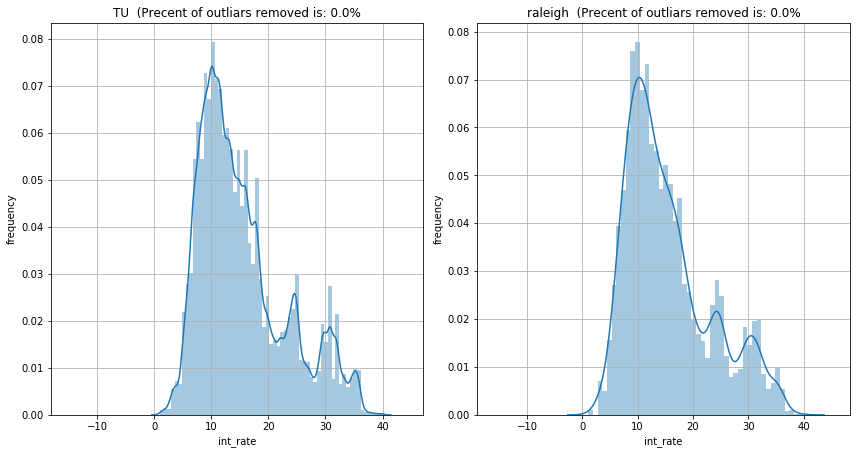

In [150]:
plot_density_histogram([df.int_rate for df in  df_list],'int_rate','frequency',df_title_list,func_flag='seaborn')

Additionally, we want to make sure the credit scores are not visibly different in Raleigh from the general population, as this might mean that the data we obtained from the town might not be representative of the general popuation.

Create a histogram to describe the distribution of credit scores in the Raleigh sample and in the general population. Do the distributions look similar? How many bins did you use?

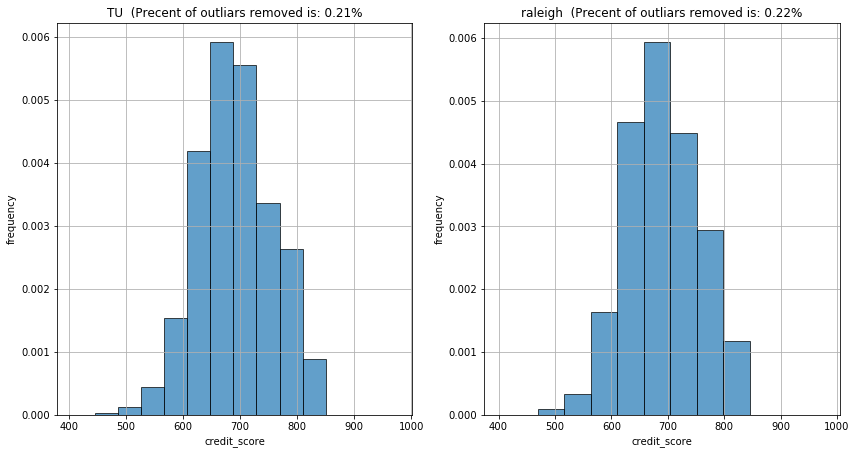

In [151]:
plot_density_histogram([df.credit_score for df in  df_list],'credit_score','frequency',df_title_list)

Describe the credit score distribution using `sns.distplot`  in the Raleigh dataframe and in TU.

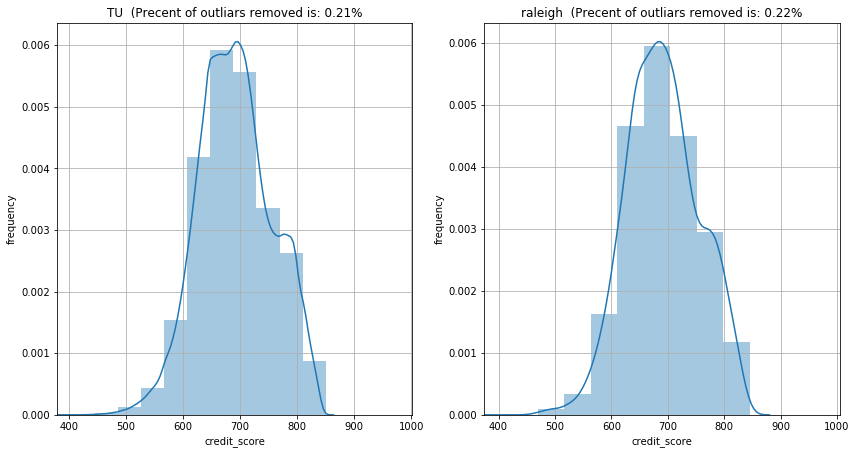

In [152]:
plot_density_histogram([df.credit_score for df in  df_list],'credit_score','frequency',df_title_list,func_flag='seaborn')

Finally, check whether the loans in both datasets have similar distributions of term (i.e. the amount of months the borrower takes the loan for). What values of term exist in the data?

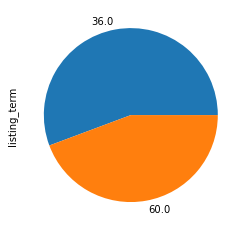

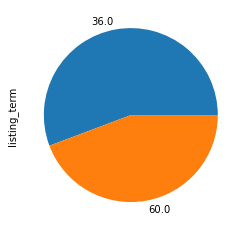

In [153]:
raleigh_df_and_tu_data["listing_term"].value_counts().plot.pie()
plt.show()
tu_data["listing_term"].value_counts().plot.pie()
plt.show()

# CLT in action

One more thing before we start the test. Our goal is to check whether, for which we'll run some statistical test (you probably already know which) which checks if something belongs to a noraml distribution with some mean and some variance. But... is activation normally distributed in the Raliegh sample? 

#+2 points if you answer without plotting
The variable is bernoli distributed. Becuse the values is only zero or one so the image of the value is on the 2D plane that the values on the X axis on zero or one.



The reason why we can assume normality is because we're checking averages of samples and we're relying on the Central Limit Theorem. We won't prove the theorem, but let's test it for a bit. 

Write a function which takes a pandas series S and a natural number n and creates a series of means of samples (with replacement) of n entries from S. Decide for yourself on the length of the output series. You can also use a different data structure if you find it more suitable as the output.

In [154]:
def create_mean_samples_and_plot_fast(values,n,num_of_means=2500):
    max_ind = len(values)-1
    num_of_bins = int(np.sqrt(num_of_means))
    random_sample = np.random.randint(0,max_ind,n*num_of_means)
    result = np.array(values[random_sample]).reshape(n,num_of_means)
    mean_list = result.mean(axis=0)
    panda_series = pd.Series(mean_list)
    return panda_series,result

Optionally- also create a function which, given the same input as above, plots a histogram of the series of means, and also indicates the mean of this series.

In [155]:
def hist_CLT(values,n,num_of_means=2500):
    series,result = create_mean_samples_and_plot_fast(values,n)
    series.hist(bins=int(math.sqrt(series.size)))
    plt.axvline(result.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.title("number of samples "+str(n))
    plt.show()

Generate plots of the series of means of activation in Raleigh and in TU for n = 1, 2, 5, 10, 100, 1000 and 1e6, and indicate their means. Does the distribution approach a normal distribution as $n\to\infty$ in your opinion?

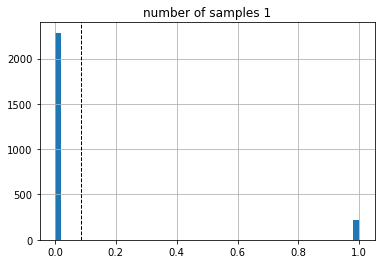

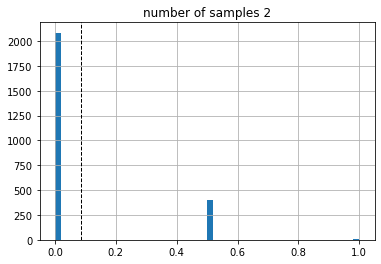

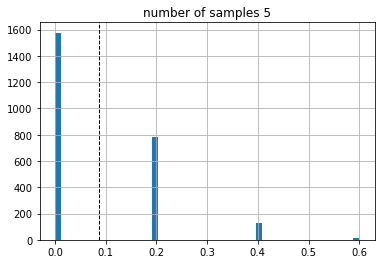

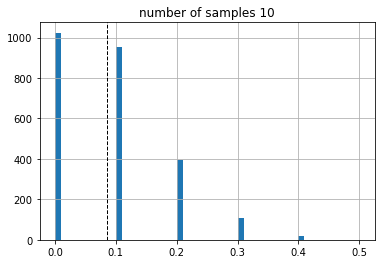

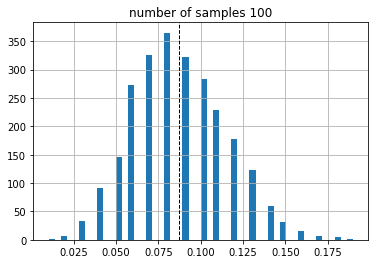

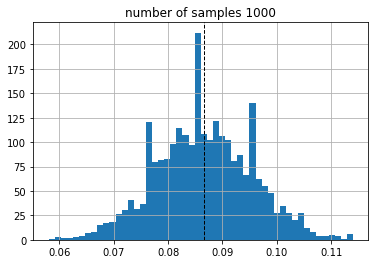

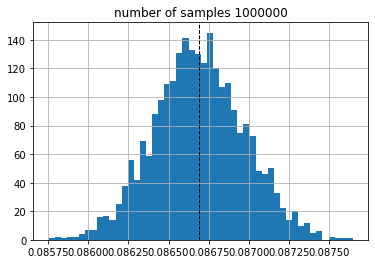

In [156]:
series_offer_accepted = raleigh_df_and_tu_data["offer_accepted"]
lst = [1,2,5,10,100, 1000, 1000000]
#lst = [1,2,5,10,100,1000]
for i in lst:
    hist_CLT(series_offer_accepted,i)

Now that your fuction is ready, it's time to make it part of our infrastucture:
* Inside the `pagayapro` repo, create a branch called `feature/{your_user_name}/clt_tester/`.
* Create a file called `clt.py` inside `~/pagayapro/users/{user_name}/assignment1/` 
* Copy the two finctions you just created into the file.
* Push your file to `main`, open a PR and ask your mentor to review it. Once approved, rebase and merge.

# Statistical test 

As mentioned in the Notion doc, the activation in Raleigh before deployment was measured at 6.85%. In this section, you will run a test to check whether the activation in Raleigh is indeed different following the flyer program. 

Run a statistical test to check whether the current activation rate in Raleigh is different from 6,85%:
1. What are your hypotheses?
2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error? What is the power of your test?
3. Is the sample mean significantly different from the past value of 6.85?
4. Interpret your results. Can you declare the program as successful in increasing activation (what is the probability of wrongfully declaring it successful)?
5. Are there any other possible explanations for the change in activation that you observed? Discuss the possible drawbacks of our current test.

Use `proportions_ztestz` from `statsmodels.stats.proportion` in order to perform the test. Are your results significant?

<ol>
    <li>Hypotheses: H0-The activation rate stays the same.<br>
        H1-The activation rate changed.


Type I error if we will conclude that flyers helps to to changed the offer rate but in reality they are not.
Type II error if we will conclude that flyers does not helps to to changed the offer rate but in reality they are.
The probability to get type I error is alpha = 1-Confidence = 1 - 0.95 = 0.05.
The probability to get type II error = beta

In [157]:
#3
count = raleigh_df_and_tu_data["offer_accepted"].sum()
nobs = raleigh_df_and_tu_data.shape[0]
value = 0.0685
stat, pval = proportions_ztest(count, nobs, value,alternative="two-sided")
print('{0:0.20f}'.format(pval))
#the number that I get(p-value is zero) is the probability that I will be wrong if I will agree with H1.

0.00000000140054917430


3. As we can see the value of p value is almost zero. It means that H1 is probabliy true and our activation rate have been changed. the changed is indeed significant. 
4. We can declare the changed is indeed significant and maybe the reason for it is the program, and we can say with 95% confidence that there was a change in the city.
5. Maybe the tests was at diffrent times and we don't know if something happen it that city that unrelated.

Do you see any possible problems in your methodology? What other factors can explain the change in activation, if such a change exists?

The factors can as following:
    see number 5.

# A/b test

In order to isolate temporal and environmental effects on activation, we'll run an a/b test, comparing the activation rate in Raleigh to that of Lubbock, TX, another town in which Pagaya operates without a flyer program. 

The activation forms for Lubbock also appear in the `offers` subdirectory of the `ASSIGNMENT1_DATA` folder. Read all files from this folder whose name contains the substring 'lubbock', and create a dataframe of final offers called `lubbock_df`, drop unnecessary rows from it, and enrich it with TU features.

In [158]:
lubbock_forms= (
    glob.glob(
        os.path.join(ASSIGNMENT1_DATA,"offers/*lubbock*")
    )
)
lubbock_df = pd.concat(map(pd.read_csv, lubbock_forms))
lubbock_df_without_duplicates = lubbock_df.sort_values(by=['offer_date']).drop_duplicates(subset='id', keep='last')
lubbock_df = lubbock_df_without_duplicates.set_index("id")
lubbock_df_and_tu_data = lubbock_df.join(tu_data, how='left',lsuffix='_left', rsuffix='_right')

What is the average interest rate in Lubbock? What is it among accepting borrowers?

In [159]:
lubbock_df_and_tu_data["offered_interest_rate"].mean()

15.505397526501767

What is the average credit score in Lubbock? What is it among accepting borrowers?

In [160]:
lubbock_df_and_tu_data["credit_score"].mean()

690.0338339222615

What is the rate of activation in Lubbock?

In [161]:
lubbock_df_and_tu_data["offer_accepted"].mean()*100

4.717314487632509

## Caution about a/b test 

Note that this is not a classical a/b test. Usually, in such a test, one creates two random subgroups from the general population and applies a manipulation to one of them in order to see if the manipulation had an effect. However, in this case, it is very complicated to isolate a random subgroup from any population and deploy the flyer program only on it.
Thus, due to production limitation, we have to make do with what we got.

In order to justify the use of an a/b test for this situation, we should at least verify that the borrower population in Lubbock and Raleigh seem as though they were randomly selected from the general population. We have actually already checked it for Raleigh above. Add TU features to the loan amount, interest rate, credit score and term comparisons and see if there any major differences between the three populations (Lubbock, Raleigh and TU).

In [162]:
df_list = [lubbock_df_and_tu_data,raleigh_df_and_tu_data]
df_title_list = ['lubbock','raleigh']

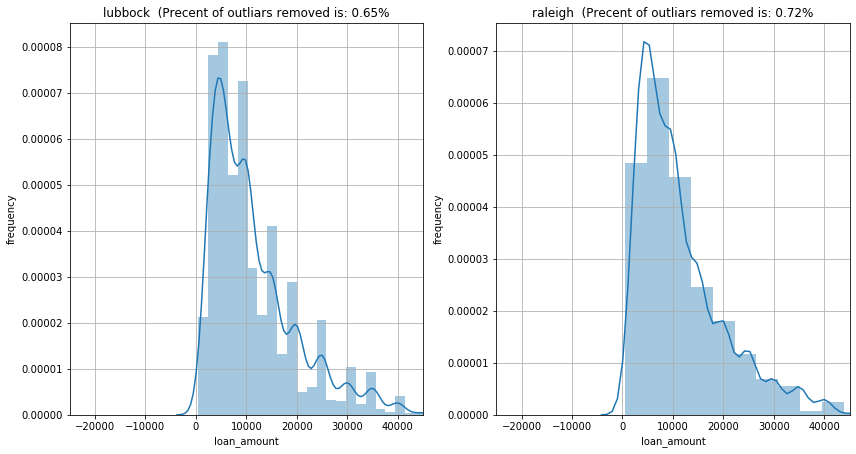

In [163]:
plot_density_histogram([df.loan_amnt for df in  df_list],'loan_amount','frequency',df_title_list,func_flag='seaborn')

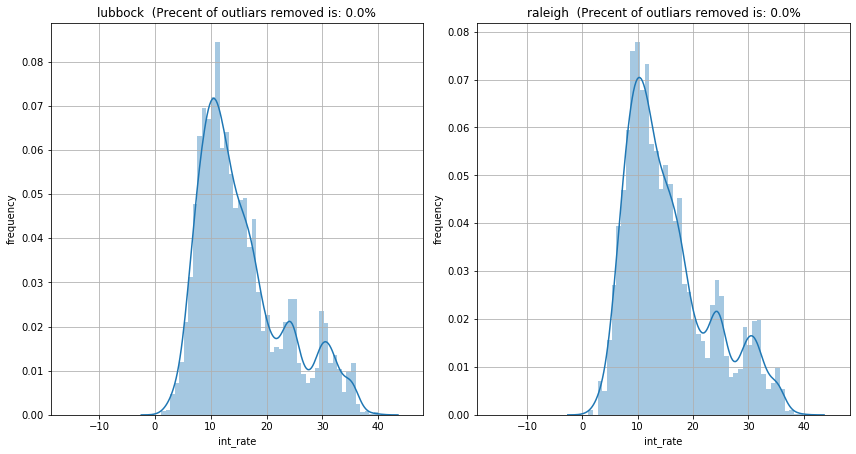

In [164]:
plot_density_histogram([df.int_rate for df in  df_list],'int_rate','frequency',df_title_list,func_flag='seaborn')

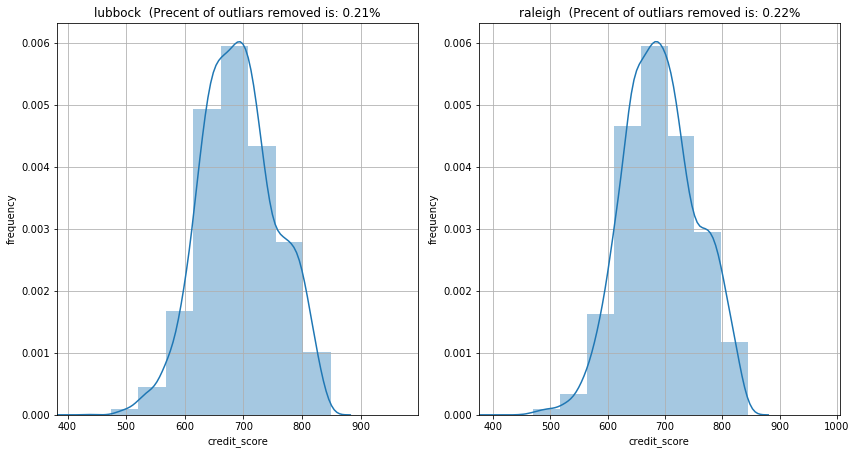

In [165]:
plot_density_histogram([df.credit_score for df in  df_list],'credit_score','frequency',df_title_list,func_flag='seaborn')

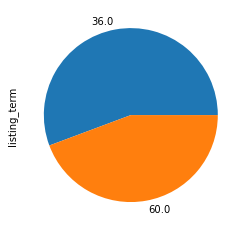

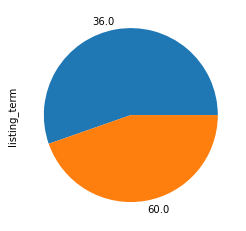

In [166]:
raleigh_df_and_tu_data["listing_term"].value_counts().plot.pie()
plt.show()
lubbock_df_and_tu_data["listing_term"].value_counts().plot.pie()
plt.show()

## Performing the test

Use the function you created in the file `clt.py` to plot the series of means of activation in Raleigh and Lubbock for samples of size n= 1, 10, 1000 and 1e6, and compare the means of the two histograms. To they seem to converge to the same value?

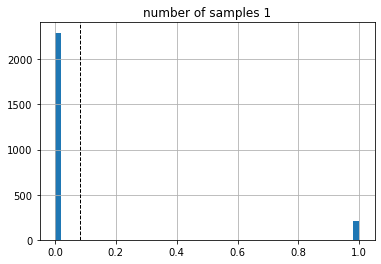

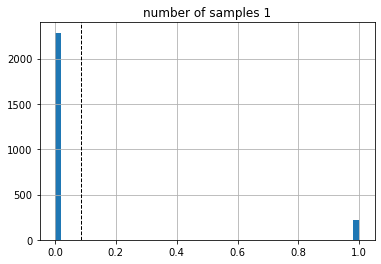

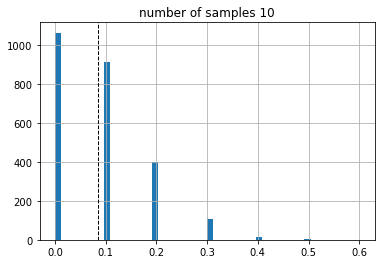

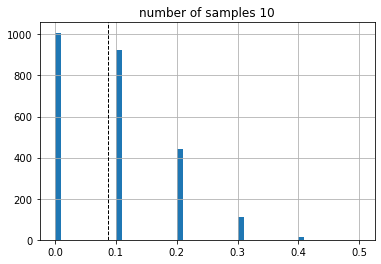

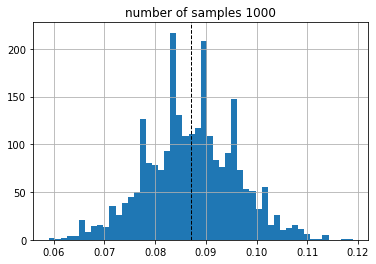

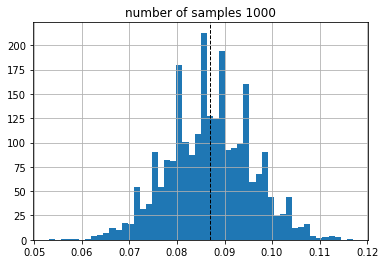

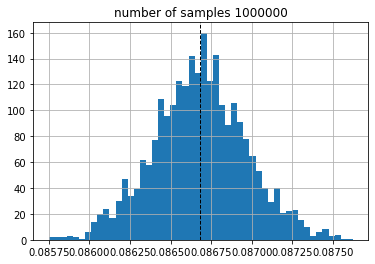

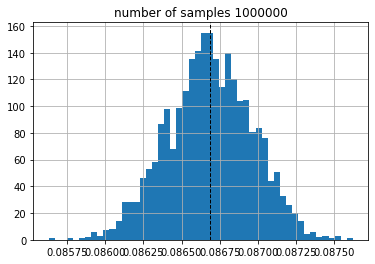

In [167]:
series_offer_accepted_raleigh = raleigh_df_and_tu_data["offer_accepted"]
series_offer_accepted_lubbock = lubbock_df_and_tu_data["offer_accepted"]
lst = [1,10,1000, 1000000]
#lst_test = [1,10,100,1000]
for i in lst:
    hist_CLT(series_offer_accepted,i)
    hist_CLT(series_offer_accepted,i)

Apply a statistical test to see whether the activation rate in Raleigh, NC is significantly larger than Lubbock, TX. Clearly state and validate your test's assumption. 

1. What are your hypotheses?  
H0 - The program didnt improve the activation rate.
H1 - The program improved the activation rate.  

2. Setting your confidence level at 95%, what is the probability of an error of type I in your test? What is the probability of a type II error?   
Type I error if we will conclude that flyers helps to to changed the offer rate but in reality they are not.
Type II error if we will conclude that flyers does not helps to to changed the offer rate but in reality they are.
The probability to get type I error is alpha/2 = (1-Confidence)/2 = (1 - 0.95)/2 = 0.025.
The probability to get type II error = beta

3. Are the two samples significantly different?
As we can see the value of p value is almost zero. It means that H1 is probabliy true and our activation rate have been changed. the changed is indeed significant. 

4. Interpret your results. Can you declare the program as successful in increasing activation? 
We can declare the changed is indeed significant and maybe the reason for it is the program, and we can say with 95% confidence that there was a change in the city.

Use the `proportions_ztestz` function from `statsmodels.stats.proportion` to perform a comparison between the activation probability in Lubbock and in Raleigh. 

5.Interprest your results; do you observe a significant change in activation in Raleigh? What is the probability of wrongfully declaring the program successful?

Maybe something happen in Raleigh that unrelated to the program.

In [168]:
# answer for 3
def get_p_value_from_two_datasets(s1,s2):
    count = [s1.sum(),s2.sum()]
    nobs = [s1.size,s2.size]
    stat, pval = proportions_ztest(count=count, nobs=nobs, alternative="larger")
    return pval

series_offer_accepted_raleigh = raleigh_df_and_tu_data["offer_accepted"]
series_offer_accepted_lubbock = lubbock_df_and_tu_data["offer_accepted"]
pval = get_p_value_from_two_datasets(series_offer_accepted_raleigh,series_offer_accepted_lubbock)
print("p-value:",pval)

p-value: 5.475858880145861e-30


# Testing for activation in sub-populations

Now that you applied the a/b test to the Lubbock and Raleigh datasets, it is now required that you make a similar comparison on different subsets of the data within various credit score and loan amount bins. To do so, let us first decide on how to segment our data.

You are asked to divide your data into 10 bins according to loan amount, and then divide each of those bins into 10 bins according to loan amount. The most staightforward way of doing this is by using the `pd.qcut` function; first dividing the data into 10 quantiles of credit score and then dividing each of these quantiles into 10 according to loan amount.

Divide your datasets as above and add two columns to your data which indicate the (credit_score, loan_amnt) of the bin.

In [169]:
tu_data['categorial_credit_score'] = pd.qcut(x=tu_data['credit_score'], q=10, labels=False)
tu_data['categorial_loan_amnt'] = 0
for credit_score_label in tu_data.categorial_credit_score.unique():
    tu_data.loc[tu_data['categorial_credit_score']==credit_score_label ,'categorial_loan_amnt'] = pd.qcut(x=tu_data[tu_data['categorial_credit_score']==credit_score_label]['loan_amnt'],q=10,labels=False)
tu_groups_by_id = tu_data.drop(labels=['sequence_num', 'credit_score', 'listing_term', 'int_rate', 'loan_amnt',
   'monthly_pmt', 'original_state'],axis=1,inplace=False)
raleigh_df_and_tu_data = raleigh_df_and_tu_data.merge(tu_groups_by_id,on='id')
lubbock_df_and_tu_data = lubbock_df_and_tu_data.merge(tu_groups_by_id,on='id')
raleigh_df_and_tu_data.head()

,sequence_num_left,requested_amount,offered_interest_rate,offer_accepted,offer_date,sequence_num_right,credit_score,listing_term,int_rate,loan_amnt,monthly_pmt,original_state,categorial_credit_score,categorial_loan_amnt
id,,,,,,,,,,,,,,
743200d3e4cc1f6f860e121294248d611350f257a7bc83df1c5b33df7bc86f94,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,3000.0,17.69,False,2018-01-01,ec10245656d9d89186fb4e5890082eea989d5967752ce7...,652,36.0,17.69,3000.0,108.0,NC,2,0
9b785f1c83a022947857aa109de2aeb3c2c54231b910ed0d6b63f0b6781cafa8,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,7000.0,17.98,False,2018-01-01,4f94dbec44bd09b1c47b08f17a62a7b58b17fc108b077f...,662,36.0,17.98,7000.0,253.0,NC,3,3
0f0b253809bb99eb4cd76ba8089f5746f2345ae3c595358c3f6fbbc52cb19c63,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,3505.0,29.58,True,2018-01-01,b27933d6634f47eef5d66650874bc0df2e1fda04a9827f...,623,36.0,29.58,3505.0,148.0,NC,1,2
e3e32f85cd78bb5002ccdc037c1818029f716e7a47911ed3b822de61c435e2c8,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,6899.0,12.56,False,2018-01-01,3dcd131256c103fccb61c75cd79ca97fa2b5e31c4ab03e...,735,36.0,12.56,6899.0,231.0,NC,7,2
3a72ae7a82244f811b37c48f57469b708207004f0111633d1b222fb75a12d867,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,3800.0,12.97,False,2018-01-01,06c005c5de6ba445d4c709b84611ac2b8542cd5d37221b...,661,36.0,12.97,3800.0,128.0,NC,3,1


Run an a/b test on each of the bins in your data and create a $10\times 10$ table containing the $p$ value of each test.

In [170]:
mat=np.zeros((10,10))
for i in range(10):
    for j in range(10):
        series_offer_accepted_raleigh = raleigh_df_and_tu_data.query("(categorial_credit_score == @i) and (categorial_loan_amnt == @j)")["offer_accepted"]
        series_offer_accepted_lubbock = lubbock_df_and_tu_data.query("(categorial_credit_score == @i) and (categorial_loan_amnt == @j)")["offer_accepted"]
        mat[i,j] = get_p_value_from_two_datasets(series_offer_accepted_raleigh,series_offer_accepted_lubbock)

Use the [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function to represent your table as a heatmap. You can also use it on a suitable table of boolean values to get a more robus representation of which experiments turned out significant.

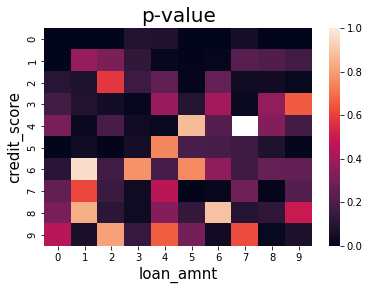

In [171]:
ax = sns.heatmap(mat, vmin=0, vmax=1)
plt.title('p-value', fontsize = 20)
plt.xlabel('loan_amnt', fontsize = 15)
plt.ylabel('credit_score', fontsize = 15)
plt.show()

What is the probability of falsely rejecting the null hypothesis in each cell? 

alpha.

What is the probability of falsely rejecting the null hypothesis in at least one of the cells (i.e. what is the **family wise error rate**)?



In other words, given that we made $m$ experiments, with confidence level $\alpha$, what is the probabilty $\mathbb{P}\left(\bigcup_i X_i \le q_{\alpha}\right)$? 
_Note_: you may assume that sampling from different bins are independent.

the probability of falsely rejecting the null hypothesis in at least one of the cells=1-(0.95)^100=0.9940

## Bonferroni correction 

One way of assuring that your FWER remains below $\alpha=0.05$ is to apply a <a href="https://en.wikipedia.org/wiki/Bonferroni_correction">**Bonferroni correction**</a>. This means that we set the signficance level of each individual test to $\alpha/m$, where $m=100$ is the number of tests (see, e.g., Wikipedia for an explanation). 

Use a Bonferroni correction on your segmented a/b test and output a $10\times10$ table of boolean values, indicating which test gave a significant result under this correction.

In [172]:
alpha = 0.05
m=100
mat_bonferroni = mat<(alpha/100)
mat_bonferroni.sum()

4

How many of your tests came out significant under this correction?

We got 4 significant results.

Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

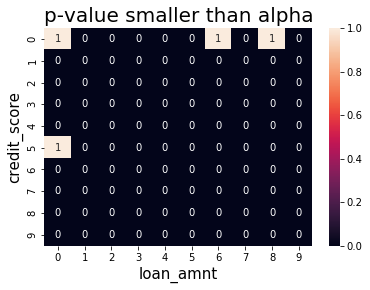

In [173]:
ax = sns.heatmap(mat_bonferroni, vmin=0, vmax=1,annot=True)
plt.title('p-value smaller than alpha', fontsize = 20)
plt.xlabel('loan_amnt', fontsize = 15)
plt.ylabel('credit_score', fontsize = 15)
plt.show()

We can see that this method is way more strict than the previous one.

## BH correction 

The Bonferroni correction is often criticized for being too restrictive, as you probably noticed in the last subsection. A more commonly used method for correcting $\alpha$ values is the Benjamini-Hochberg method. You can <a href="https://www.youtube.com/watch?v=K8LQSvtjcEo">check out the quest</a> for a nice explanation about it.

Start by arranging the $p$-values of your original test as a series and listing them in ascending order. You can use the `pd.DataFrame.stack` and `pd.Series.sort_values` methods.

In [174]:
mat_reshape = np.reshape(mat, (100,))
series = pd.Series(mat_reshape)
series.sort_values(ascending=True, inplace=True)

Plot your sorted $p$-values

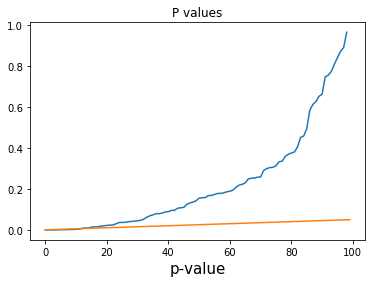

In [175]:
new_series = [((i*alpha)/m) for i in range(1,len(series)+1)]
plt.plot(series.values)
plt.plot(new_series)
plt.xlabel('index', fontsize = 15)
plt.xlabel('p-value', fontsize = 15)
plt.title("P values")
plt.show()

For each entry of the new series, compute the value compute the value $\frac{i}{m}\cdot\alpha$, where $i$ is the ordinal place of the entry (i.e. 1,2,...len(series)), $m=100$ and $\alpha=0.05$ as above. Add a plot of these values to your $p$-values plot.

In [176]:
vector = np.array(range(1,101,1))*(alpha/m)

Find the largest index $i$ for which the $p$-value in the $i$-th place in the series is smaller than $\frac{i}{m}\cdot\alpha$. That is- the last index in the plot you just created where the $p$-values line lies below the _adjusted_-$\alpha$ line.

Reject the null hypothesis for all test before and including this index, and accept it for all others. Reformat your table into a $10\times 10$ dataframe; for which bins did we get a significant result in the corrected test?

In [177]:
final_matrix = series<vector

In [178]:
value = 0
value_list = series.values
for i, e1 in enumerate(value_list):
    if (value_list[i] < ((i*alpha)/m)):
        value = i
print("The last index is:",value," So we will reject the null hypothesis for all test before and including this index.")

The last index is: 11  So we will reject the null hypothesis for all test before and including this index.


Visualize your result using the [seaborn.heatmap]() function and compare to the previous heatmap.

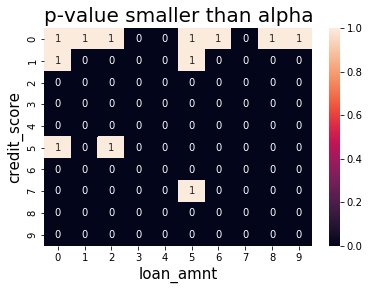

In [179]:
final_matrix = np.reshape(final_matrix.sort_index().values,(10,10))
ax = sns.heatmap(final_matrix, vmin=0, vmax=1,annot=True)
plt.title('p-value smaller than alpha', fontsize = 20)
plt.xlabel('loan_amnt', fontsize = 15)
plt.ylabel('credit_score', fontsize = 15)
plt.show()

We can see that this method is more moderate than the previous one.

### Validating your results

You can validate your results (for both corrections) using the <a href= "https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html">`statsmodels.stats.multitest.multipletests`</a> package.

In [180]:
from statsmodels.stats.multitest import multipletests

In [181]:
bonferroni_test = multipletests(mat_reshape,alpha=0.05,method = "bonferroni",returnsorted=False)[0]

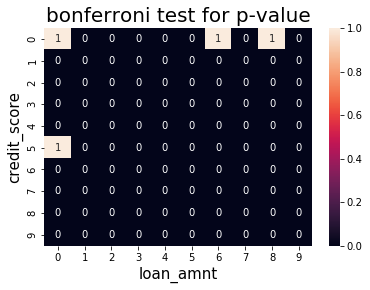

In [182]:
bonferroni_test = np.reshape(bonferroni_test,(10,10))
ax = sns.heatmap(bonferroni_test, vmin=0, vmax=1,annot=True)
plt.title('bonferroni test for p-value', fontsize = 20)
plt.xlabel('loan_amnt', fontsize = 15)
plt.ylabel('credit_score', fontsize = 15)
plt.show()

In [183]:
fdr_bh_test = multipletests(mat_reshape,alpha=0.05,method = "fdr_bh",returnsorted=False)[0]

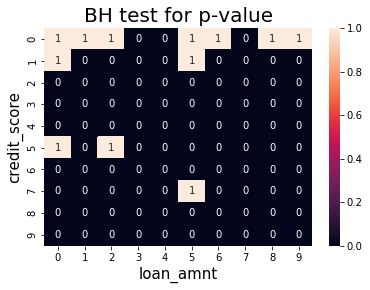

In [184]:
fdr_bh_test = np.reshape(fdr_bh_test,(10,10))
ax = sns.heatmap(fdr_bh_test, vmin=0, vmax=1,annot=True)
plt.title('BH test for p-value', fontsize = 20)
plt.xlabel('loan_amnt', fontsize = 15)
plt.ylabel('credit_score', fontsize = 15)
plt.show()

Our results is the same. Thank you for reading!!!